In [89]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
data = pd.read_parquet('cleaned.parquet')

non_factor_cols = {'permno', 'yyyymm', 'monthid', 'ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind', 'PRC', 'RET', 'SHROUT', 'ret_f1', 'ret_f2', 'ret_f3', 'ret_f4', 'ret_f5', 'ret_f6', 'ret_f7', 'ret_f8', 'ret_f9', 'ret_f10', 'ret_f11', 'ret_f12', 'date_x', 'fdate', 'ret', 'date_y', 'date'}
factor_cols = set(data.columns) - non_factor_cols

In [ ]:
# need this to be inputted
# selected_factors = ['mktcap', 'trend_factor', 'ltr60', 'rolling_z_score', 'tail_2y', 'xret_20', 'DiVYield', 'ivol', 'MoneyFlowIndex_20', 'AbsAccrual', 'EP', 'NOA', 'KDJ_20', 'dHHI', 'DNOA', 'RDG', 'SECUDEBT', 'RD_P']

# Trying top 10 factors
selected_factors = ['mean_reversion_signal', 'RD_P', 'trend_factor', 'Accrual', 'range_120', 'range_20', 'xret_indsize_std120', 'RD_SALE', 'rolling_z_score', 'FCF_P']

### Obtaining Betas From Training

In [92]:
train_data = data[data['yyyymm'] < 201501].copy()

train_factors = train_data[['permno', 'yyyymm'] + selected_factors].copy()
train_returns = train_data[['permno', 'yyyymm', 'ret_f1']].copy()

regression_data = pd.merge(train_factors, train_returns, on=['permno', 'yyyymm'], how='inner')
stock_groups = regression_data.groupby('permno')
results = []
min_observations = len(selected_factors) + 2 

In [93]:
for permno, group in stock_groups:
    group = group.dropna(subset=['ret_f1'] + selected_factors) # Drop rows with NaNs in relevant columns
    
    if len(group) >= min_observations:
        Y = group['ret_f1']
        X = group[selected_factors]
        X = sm.add_constant(X)

        try:
            model = sm.OLS(Y, X, missing='drop').fit()
            stock_result = {'permno': permno, 'alpha': model.params.get('const', np.nan)}
            for factor in selected_factors:
                stock_result[f'{factor}_beta'] = model.params.get(factor, np.nan)
            results.append(stock_result)

        except Exception as e:
            print(f"Could not run regression for permno {permno}: {e}")

stock_betas_df = pd.DataFrame(results)

In [94]:
beta_cols = [col for col in stock_betas_df.columns if '_beta' in col]
cols_to_average = ['alpha'] + beta_cols
average_betas_and_alpha = stock_betas_df[cols_to_average].mean()

average_betas_and_alpha_df = pd.DataFrame(average_betas_and_alpha).T
average_betas_and_alpha_df.index = ['average']

In [95]:
print(average_betas_and_alpha_df)

           alpha  mean_reversion_signal_beta  RD_P_beta  trend_factor_beta  \
average  0.18462                    0.000129  -0.086221           0.006028   

         Accrual_beta  range_120_beta  range_20_beta  \
average      0.000308       -0.003293       0.004164   

         xret_indsize_std120_beta  RD_SALE_beta  rolling_z_score_beta  \
average                   0.01217      0.216653             -0.002226   

         FCF_P_beta  
average    0.020057  


### Backtesting Linear Model
r̃_{i,t} = â₀ + b̂₁F1_{i,t} + b̂₂F2_{i,t} + ... + b̂_K Fk_{i,t} for stocks i at t, then calculating decile returns

In [96]:
backtest_data = data[data['yyyymm'] >= 201501].copy()
backtest_data['monthid'] = backtest_data['monthid'] - 420

In [97]:
avg_alpha = average_betas_and_alpha_df['alpha']['average']
avg_betas = average_betas_and_alpha_df[[col for col in average_betas_and_alpha_df.columns if '_beta' in col]].iloc[0]
avg_betas.index = [col.replace('_beta', '') for col in avg_betas.index]

factors_for_prediction = [factor for factor in selected_factors if factor in backtest_data.columns]
backtest_data['predicted_ret'] = avg_alpha

for factor in factors_for_prediction:
    if factor in avg_betas:
        backtest_data['predicted_ret'] += backtest_data[factor] * avg_betas[factor]

In [98]:
portfolio_returns = []
monthly_groups = backtest_data.groupby('yyyymm')

for month, group in monthly_groups:
    group = group.dropna(subset=['predicted_ret', 'ret_f1'])

    if len(group) < 10:
        continue
    try:
        group_copy = group.copy()
        group_copy.loc[:, 'decile'] = pd.qcut(group_copy['predicted_ret'], 10, labels=False, duplicates='drop') + 1
        group = group_copy 
    except ValueError as e:
        print(f"Could not form deciles for month {month} due to: {e}. Skipping.")
        continue

    if 1 not in group['decile'].values or 10 not in group['decile'].values:
        continue

    long_portfolio_ret = group[group['decile'] == 10]['ret_f1'].mean()
    short_portfolio_ret = group[group['decile'] == 1]['ret_f1'].mean()

    if pd.isna(long_portfolio_ret) or pd.isna(short_portfolio_ret):
        continue

    hedge_return = long_portfolio_ret - short_portfolio_ret
    portfolio_returns.append({'yyyymm': month, 'hedge_return': hedge_return})

hedge_portfolio_df = pd.DataFrame(portfolio_returns)
hedge_portfolio_df['yyyymm'] = pd.to_datetime(hedge_portfolio_df['yyyymm'], format='%Y%m')
hedge_portfolio_df = hedge_portfolio_df.set_index('yyyymm')

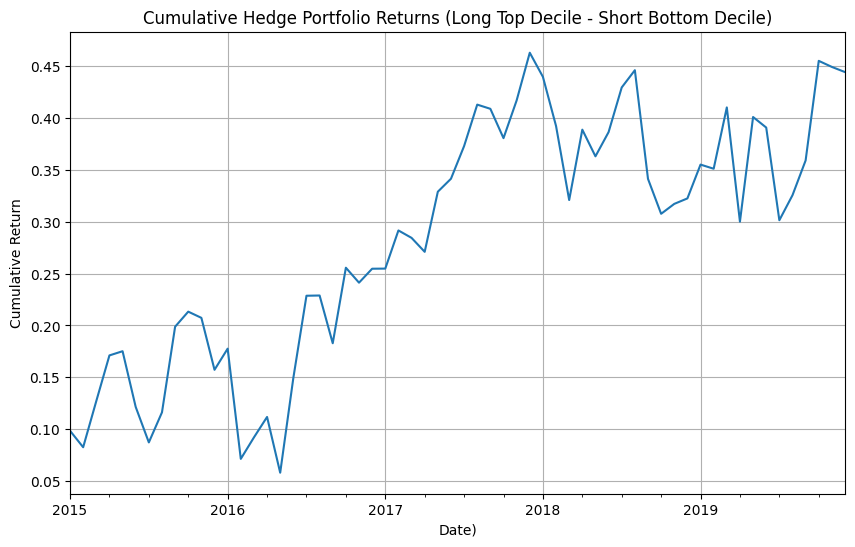

In [99]:
hedge_portfolio_df['cumulative_return'] = (1 + hedge_portfolio_df['hedge_return']).cumprod() - 1
plt.figure(figsize=(10, 6))
hedge_portfolio_df['cumulative_return'].plot(title='Cumulative Hedge Portfolio Returns (Long Top Decile - Short Bottom Decile)')
plt.xlabel('Date)')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

### Analysis 
(1) Raw return 
(2)Sharpe ratio
(3) CAPM alpha
(4) Fama-French 3-Factor alpha
(5) Information Ratio
using 3-factor model

In [100]:
hedge_portfolio_df.head()

,hedge_return,cumulative_return
yyyymm,,
2015-01-01,0.098442,0.098442
2015-02-01,-0.014479,0.082537
2015-03-01,0.041174,0.127110
2015-04-01,0.039050,0.171124
2015-05-01,0.003455,0.175170


In [101]:
ff_factors = pd.read_sas('ff_factors_monthly.sas7bdat')
ff_factors['monthid'] = ff_factors['DATEFF'].dt.strftime('%Y%m').astype(int)
ff_factors.set_index('monthid', inplace=True)
ff_factors.head()

,DATEFF,SMB,HML,MKTRF,RF,UMD
monthid,,,,,,
199501,1995-01-31,-0.0350,0.0257,0.0180,0.0042,-0.0181
199502,1995-02-28,-0.0066,0.0108,0.0363,0.0040,-0.0039
199503,1995-03-31,-0.0016,-0.0215,0.0219,0.0046,0.0043
199504,1995-04-28,-0.0049,0.0171,0.0211,0.0044,0.0179
199505,1995-05-31,-0.0255,0.0229,0.0290,0.0054,-0.0042


In [102]:
hedge_portfolio_df_copy = hedge_portfolio_df.copy()
hedge_portfolio_df_copy['monthid'] = hedge_portfolio_df_copy.index.strftime('%Y%m').astype(int)

hedge_portfolio_df_copy = pd.merge(hedge_portfolio_df_copy, ff_factors, on='monthid', how='left')
hedge_portfolio_df_copy.set_index('monthid', inplace=True)

# Calculate excess returns
hedge_portfolio_df_copy['excess_return'] = hedge_portfolio_df_copy['hedge_return'] - hedge_portfolio_df_copy['RF']

analytics = {}

analytics['raw_return'] = hedge_portfolio_df_copy['hedge_return'].mean() * 12
analytics['sharpe_ratio'] = (hedge_portfolio_df_copy['excess_return'].mean() * 12) / (hedge_portfolio_df_copy['excess_return'].std() * np.sqrt(12))

# CAPM
X = sm.add_constant(hedge_portfolio_df_copy['MKTRF'])
capm_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X).fit()
analytics['capm_alpha'] = capm_model.params['const'] * 12

# FF3
X_ff3 = sm.add_constant(hedge_portfolio_df_copy[['MKTRF', 'SMB', 'HML']])
ff3_model = sm.OLS(hedge_portfolio_df_copy['excess_return'], X_ff3).fit()
analytics['ff3_alpha'] = ff3_model.params['const'] * 12

# Information Ratio
hedge_portfolio_df_copy['benchmark_return'] = hedge_portfolio_df_copy['MKTRF'] + hedge_portfolio_df_copy['RF']
analytics['information_ratio'] = ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).mean() * 12) / ((hedge_portfolio_df_copy['excess_return'] - hedge_portfolio_df_copy['benchmark_return']).std() * np.sqrt(12))

print("Analytics:")
for key, value in analytics.items():
    print(f"{key}: {value:.4f}")

Analytics:
raw_return: 0.0834
sharpe_ratio: 0.5240
capm_alpha: 0.0852
ff3_alpha: 0.0787
information_ratio: -0.2187
